In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm.notebook import tnrange
from scipy.linalg import solve_banded

In [2]:
def solve_linear(a, b, c, d):
    nf = len(d)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    for it in range(1, nf):
        mc = ac[it - 1] / bc[it - 1]
        bc[it] = bc[it] - mc * cc[it - 1] 
        dc[it] = dc[it] - mc * dc[it - 1]
    xc = bc
    xc[-1] = dc[-1] / bc[-1]
    for il in range(nf - 2, -1, -1):
        xc[il] = (dc[il] - cc[il] * xc[il + 1]) / bc[il]
    return xc

In [3]:
K = 1e8
E = 1.02e5
alpha = 1.0
Q = 7e5
ro = 830
C = 1990
lambd = 0.13
D = 8e-12
R = 8.31
T0 = 293 # начальная температура
Tm = T0 + Q / C # конечная температура
kappa = lambd / (ro * C)
U = (2 * K * lambd / (Q * ro * Q / C) * T0 / Tm * ((R * Tm * Tm / E) ** 2) * np.exp(-E / (R * Tm))) ** 0.5
beta = R * Tm / E
gamma = R * Tm * Tm / (E * Q / C)
delta_h = kappa / U
delta_r = beta * delta_h
delta_d = D / U
Le = delta_d / delta_h

# Регулярный режим
# D = 8e-8
# K = 1.6e6
# E = 8e4

# Двухпериодический режим
# D = 8e-12
# K = 4.6e6
# E = 8.5e4

# Хаос
# D = 8e-12
# K = 1e8
# E = 1.02e5

In [4]:
print(Le, K*np.exp(-E/(R*Tm)))

0.0001016430769230769 0.5398485148070851


In [5]:
a = 0
b = 3e-2
dz = 1e-4
z_steps = int((b-a) / dz)

teta = 500
dt = 1e-2
t_steps = int(teta / dt)

r_X = D * dt / (dz ** 2)
r_T = kappa * dt / (dz ** 2)

In [6]:
print(r_X, r_T)
print(delta_r)

8e-06 0.07870678694678211
0.00021850815738610585


In [7]:
t_start = np.zeros(z_steps, dtype=np.float64)
x_start = np.zeros(z_steps, dtype=np.float64)

for i in range(1):
    t_start[i] = Tm
    x_start[i] = 0
for i in range(1, z_steps):
    t_start[i] = T0
    x_start[i] = 1

In [8]:
def W(X, T):
    return -K*(X ** alpha)*np.exp(-E/(R*T)) 

In [9]:
def W_vectorized(X, T):
    return -K*np.multiply((np.power(X, alpha)), np.exp(-E/R * np.reciprocal(T)))

In [10]:
def solve(solver):
    Ts = [t_start]
    Xs = [x_start]
    
    for cur_iter in tnrange(1, t_steps + 1):
        t = dt * cur_iter
        cur_t, cur_x = solver(t, Ts[-1], Xs[-1])
        Ts.append(cur_t)
        Xs.append(cur_x)

    return Ts, Xs

In [11]:
def evident_opposite(t, prevT, prevX):
    next_t_row = np.zeros(z_steps, dtype=np.float64)
    next_x_row = np.zeros(z_steps, dtype=np.float64)
    
    for i in range(1, z_steps - 1):
        prev_t = prevT[i - 1]
        next_t = prevT[i + 1]
        cur_t = prevT[i]
        
        prev_x = prevX[i - 1]
        next_x = prevX[i + 1]
        cur_x = prevX[i]
        
        next_t_row[i] = cur_t + r_T * (prev_t + next_t - 2 * cur_t) - Q/C * dt * W(cur_x, cur_t)
        next_x_row[i] = cur_x + r_X * (prev_x + next_x - 2 * cur_x) + dt * W(cur_x, cur_t)
    
    next_t_row[0] = Tm
    next_t_row[z_steps - 1] = next_t_row[z_steps - 2]
    
    next_x_row[0] = 0
    next_x_row[z_steps - 1] = next_x_row[z_steps - 2]
    return next_t_row, next_x_row

In [12]:
def non_evident(t, prevT, prevX):
    T_r = dt * kappa / (dz ** 2)
    X_r = dt * D / (dz ** 2)
    
    T_a = np.repeat(T_r, z_steps)
    T_b = np.repeat(-1 - 2 * T_r, z_steps)
    T_c = np.repeat(T_r, z_steps)
    T_a[-2] = 0
    T_b[0] = 1
    T_b[z_steps - 1] = 1
    T_c[1] = 0
    
    X_a = np.repeat(X_r, z_steps)
    X_b = np.repeat(-1 - 2 * X_r, z_steps)
    X_c = np.repeat(X_r, z_steps)
    X_a[-2] = 0
    X_b[0] = 1
    X_b[z_steps - 1] = 1
    X_c[1] = 0
    
    W_values = W_vectorized(prevX, prevT)
    X_d = -dt * W_values - prevX
    T_d = Q * dt / C * W_values - prevT
    
    X_d[0] = 0
    T_d[0] = Tm
    T_d[z_steps - 1] = T0    
    X_d[z_steps - 1] = 1
    
    newT = solve_banded((1, 1), np.array([T_c, T_b, T_a]), T_d, overwrite_ab=True, overwrite_b=True, check_finite=True)
    newX = solve_banded((1, 1), np.array([X_c, X_b, X_a]), X_d, overwrite_ab=True, overwrite_b=True, check_finite=True)
    return newT, newX

In [13]:
Ts, Xs = solve(non_evident)

In [14]:
def build_gif(Ys, name, step=500):
    fig, ax = plt.subplots(figsize=(16,9))
    min_y = np.min(Ys)
    max_y = np.max(Ys)
    ax.set_ylim(0.9*min_y, max_y*1.1)
    x = np.linspace(a, b, num=z_steps)
    line, = ax.plot(x, Ys[0])
 
    def animate(i):
        line.set_ydata(Ys[i])  # update the data
        return line,
 
    # Init only required for blitting to give a clean slate.
    def init():
        line.set_ydata(np.ma.array(x, mask=True))
        return line,
 
    ani = animation.FuncAnimation(fig, animate, tnrange(0, t_steps, step), init, blit=True)
    ani.save(name + '.gif', writer='pillow', fps=600)

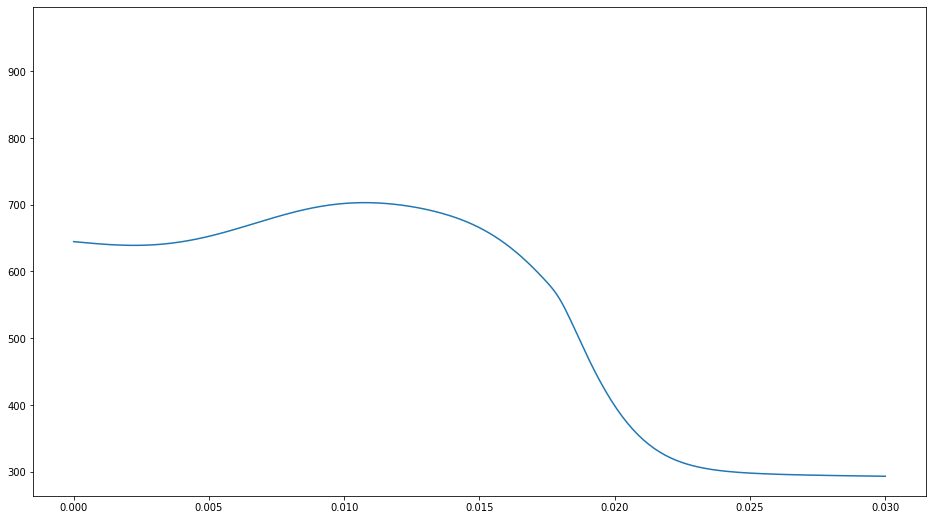

In [15]:
build_gif(Ts, 'T')

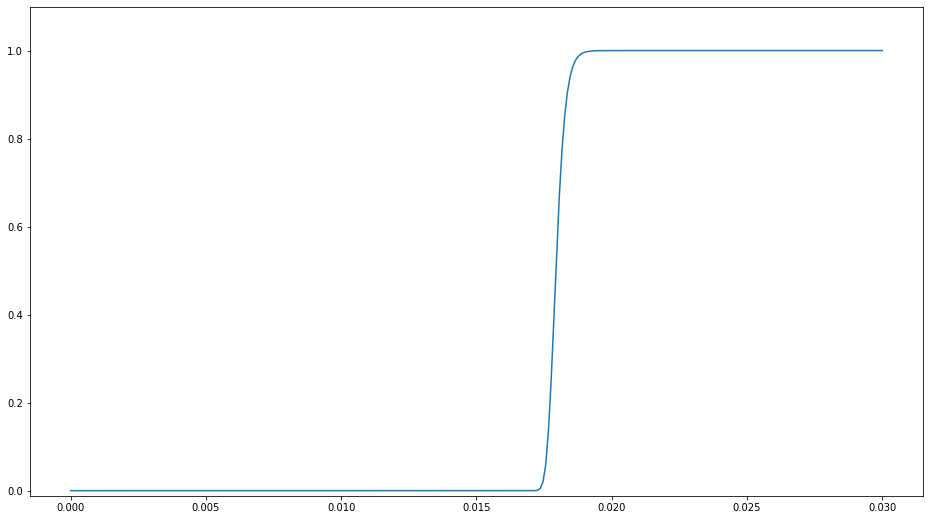

In [16]:
build_gif(Xs, 'X')

In [17]:
def show_series(Ys, step, name):
    zs = np.linspace(a, b, z_steps)
    plt.subplots(figsize=(16,9))
    bound_Ys = np.apply_along_axis(np.amax, 0, np.array(Ys))
    plt.plot(zs, bound_Ys, linestyle='--', color='black', linewidth=2.0)
    for i in range(0, len(Ys), step):
        plt.plot(zs, Ys[i])
    plt.xlabel('Ось Z', fontsize=18)
    plt.ylabel('Значение ' + name, fontsize=18)
    plt.savefig(name + '_series.png')
    plt.show()

In [18]:
def show_w(step):
    zs = np.linspace(a, b, z_steps)
    plt.subplots(figsize=(16,9))
    Ws = np.array([W_vectorized(Xs[i], Ts[i]) for i in range(len(Xs))])
    bound_Ws = np.apply_along_axis(np.amin, 0, Ws)
    plt.plot(zs, bound_Ws, linestyle='--', color='black', linewidth=2.0)
    for i in range(0, len(Xs), step):
        plt.plot(zs, Ws[i])
    plt.xlabel('Ось Z', fontsize=18)
    plt.ylabel('Значение W', fontsize=18)
    plt.savefig('W_seriens.png')
    plt.show()

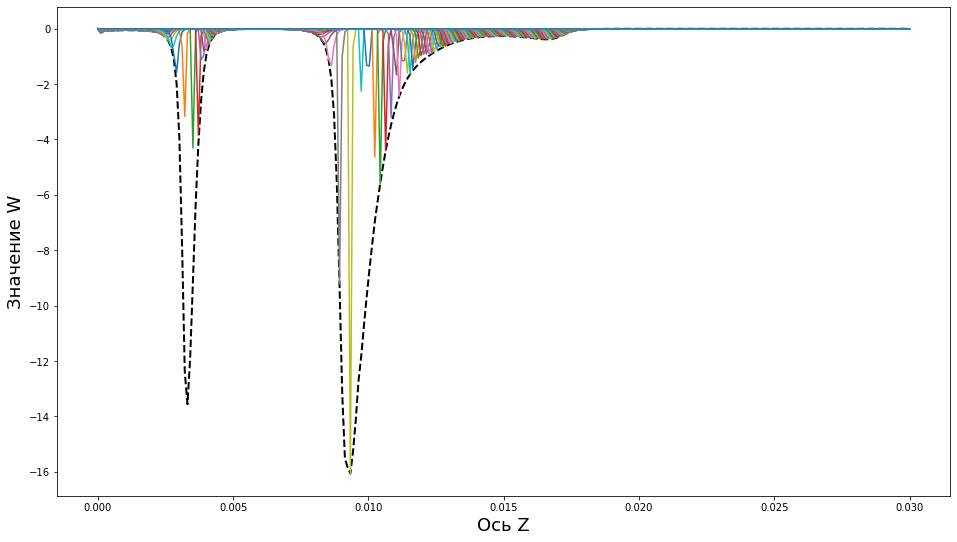

In [19]:
show_w(50)

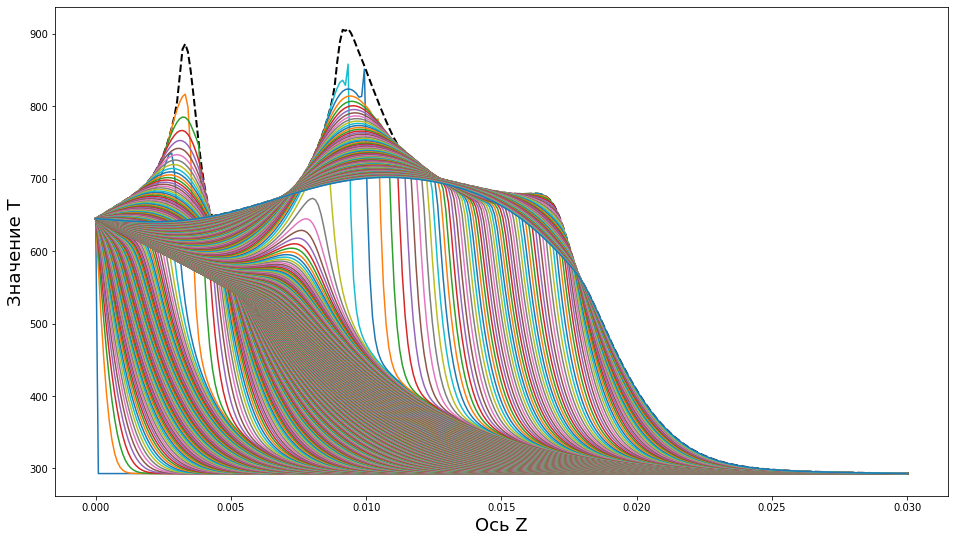

In [20]:
show_series(Ts, 100, 'T')

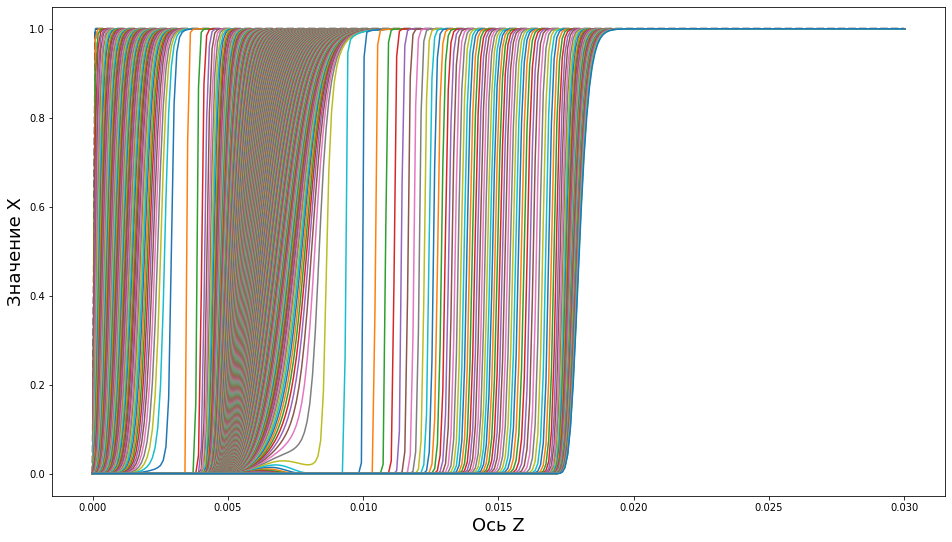

In [21]:
show_series(Xs, 100, 'X')